In [1]:
import argparse
import os
import torch
import pyro
import json
import math
from tqdm import tqdm
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import PyroOptim
from torch.optim import Adam
import pyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.cm import get_cmap
from scipy.sparse import csr_matrix
from scipy.spatial import KDTree

import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import lightning as L
import torch.nn.functional as F

import subprocess
import warnings
warnings.filterwarnings("ignore")
from importlib import reload

# this ensures that I can update the class without losing my variables in my notebook
import xenium_cluster
reload(xenium_cluster)
from xenium_cluster import XeniumCluster
from utils.metrics import *

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
def prepare_DLPFC_data(
    section_id=151670,
    num_pcs=5,
    log_normalize=True,
):
    section = ad.read_h5ad(f"data/DLPFC/{section_id}.h5ad")
    section.var["feature_name"] = section.var.index

    spatial_locations = section.obs[["array_row", "array_col"]]
    spatial_locations.columns = ["row", "col"]

    clustering = XeniumCluster(data=section.X, dataset_name="DLPFC")
    clustering.xenium_spot_data = section
    if log_normalize:
        clustering.xenium_spot_data.X = np.log1p(clustering.xenium_spot_data.X)

    sc.tl.pca(clustering.xenium_spot_data, svd_solver='arpack', n_comps=num_pcs)
    data = clustering.xenium_spot_data.obsm["X_pca"]

    return data, spatial_locations, clustering

def prepare_Xenium_data(
        dataset="hBreast", 
        spots=True, 
        spot_size=100, 
        third_dim=False, 
        log_normalize=True,
        likelihood_mode="PCA",
        num_pcs=5,
        hvg_var_prop=0.5,
        min_expressions_per_spot=10
    ):

    data_filepath = f"data/spot_data/{dataset}/hBreast_SPOTSIZE={spot_size}um_z={third_dim}.h5ad"
    
    if spots:

        if os.path.exists(data_filepath):

            clustering = XeniumCluster(data=None, dataset_name="hBreast")
            clustering.set_spot_size(spot_size)
            print("Loading data.")
            clustering.xenium_spot_data = ad.read_h5ad(data_filepath)

        else:

            # Path to your .gz file
            file_path = f'data/{dataset}/transcripts.csv.gz'

            # Read the gzipped CSV file into a DataFrame
            df_transcripts = pd.read_csv(file_path, compression='gzip')
            df_transcripts["error_prob"] = 10 ** (-df_transcripts["qv"]/10)
            df_transcripts.head(), df_transcripts.shape

            # drop cells without ids
            df_transcripts = df_transcripts[df_transcripts["cell_id"] != -1]

            # drop blanks and controls
            df_transcripts = df_transcripts[~df_transcripts["feature_name"].str.startswith('BLANK_') & ~df_transcripts["feature_name"].str.startswith('NegControl')]

            clustering = XeniumCluster(data=df_transcripts, dataset_name="hBreast")
            clustering.set_spot_size(spot_size)

            if not os.path.exists(data_filepath):
                print("Generating and saving data")
                clustering.create_spot_data(third_dim=third_dim, save_data=True)
                clustering.xenium_spot_data.write_h5ad(data_filepath)

        print("Number of spots: ", clustering.xenium_spot_data.shape[0])
        clustering.xenium_spot_data = clustering.xenium_spot_data[clustering.xenium_spot_data.X.sum(axis=1) > min_expressions_per_spot]
        print("Number of spots after filtering: ", clustering.xenium_spot_data.shape[0])

        if log_normalize:
            clustering.normalize_counts(clustering.xenium_spot_data)

        if likelihood_mode == "PCA":
            sc.tl.pca(clustering.xenium_spot_data, svd_solver='arpack', n_comps=num_pcs)
            data = clustering.xenium_spot_data.obsm["X_pca"]
        elif likelihood_mode == "HVG":
            min_dispersion = torch.distributions.normal.Normal(0.0, 1.0).icdf(hvg_var_prop)
            clustering.filter_only_high_variable_genes(clustering.xenium_spot_data, flavor="seurat", min_mean=0.0125, max_mean=1000, min_disp=min_dispersion)
            clustering.xenium_spot_data = clustering.xenium_spot_data[:,clustering.xenium_spot_data.var.highly_variable==True]
            data = clustering.xenium_spot_data.X
        elif likelihood_mode == "ALL":
            data = clustering.xenium_spot_data.X

        spatial_locations = clustering.xenium_spot_data.obs[["row", "col"]]
    
    # prepare cells data
    else:

        cells = df_transcripts.groupby(['cell_id', 'feature_name']).size().reset_index(name='count')
        cells_pivot = cells.pivot_table(index='cell_id', 
                                        columns='feature_name', 
                                        values='count', 
                                        fill_value=0)
        
        location_means = df_transcripts.groupby('cell_id').agg({
            'x_location': 'mean',
            'y_location': 'mean',
            'z_location': 'mean'
        }).reset_index()

        cells_pivot = location_means.join(cells_pivot, on='cell_id')

        if log_normalize:
            # log normalization
            cells_pivot.iloc[:, 4:] = np.log1p(cells_pivot.iloc[:, 4:])

        if likelihood_mode == "PCA":
            pca = PCA(n_components=num_pcs)
            data = pca.fit_transform(cells_pivot.iloc[:, 4:])

        elif likelihood_mode == "HVG":
            genes = cells_pivot.iloc[:, 4:]
            gene_variances = genes.var(axis=0)
            gene_variances = gene_variances.sort_values(ascending=False)
            gene_var_proportions = (gene_variances / sum(gene_variances))
            relevant_genes = list(gene_var_proportions[(gene_var_proportions.cumsum() < hvg_var_prop)].index)
            cells_pivot.iloc[:, 4:] = cells_pivot.iloc[:, 4:][[relevant_genes]]
            data = cells_pivot.iloc[:, 4:]

        elif likelihood_mode == "ALL":
            data = cells_pivot.iloc[:, 4:]

        spatial_locations = cells_pivot[["x_location", "y_location"]]


    return data, spatial_locations, clustering # the last one is to regain var/obs access from original data

In [3]:
spot_size = 100
data_mode="PCA"
num_pcs=25
hvg_var_prop=0.5
dataset_name="hBreast"
kmeans_init=True
spatial_init=True
spatial_normalize=True
num_clusters=17
batch_size=16
neighborhood_size=2
neighborhood_agg="sum"
concentration_amplification=5
uncertainty_values = [0.25, 0.5, 0.75, 0.9, 0.99]
evaluate_markers=False

In [4]:
gene_data, spatial_locations, original_adata = prepare_Xenium_data(
    dataset="hBreast", 
    spots=True, 
    spot_size=spot_size, 
    third_dim=False, 
    log_normalize=True, 
    likelihood_mode=data_mode, 
    num_pcs=num_pcs,
    hvg_var_prop=hvg_var_prop,
    min_expressions_per_spot=0
)

Loading data.
Number of spots:  6138
Number of spots after filtering:  6138


In [5]:
def save_filepath(model, component, sample_for_assignment=None):

    total_file_path = (
        f"results/{dataset_name}/{model}/{component}/{data_file_path}/"
        f"KMEANSINIT={kmeans_init}/NEIGHBORSIZE={neighborhood_size}/NUMCLUSTERS={num_clusters}"
        f"/SPATIALINIT={spatial_init}/SAMPLEFORASSIGNMENT={sample_for_assignment}"
        f"/SPATIALNORM={spatial_normalize}/SPATIALPRIORMULT={concentration_amplification}/SPOTSIZE={spot_size}/AGG={neighborhood_agg}"
    )

    return total_file_path

Batch Size is 16.


100%|██████████| 6138/6138 [00:00<00:00, 27123.06it/s]


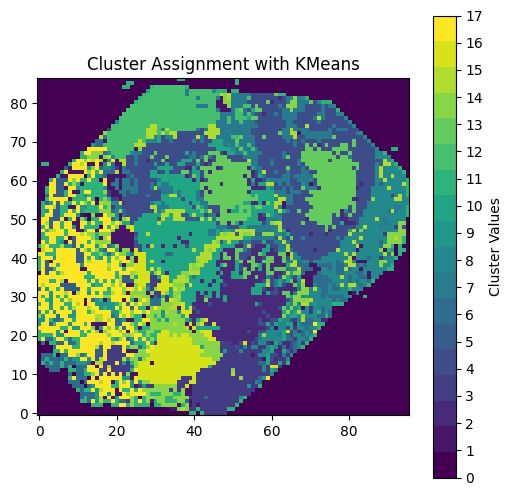

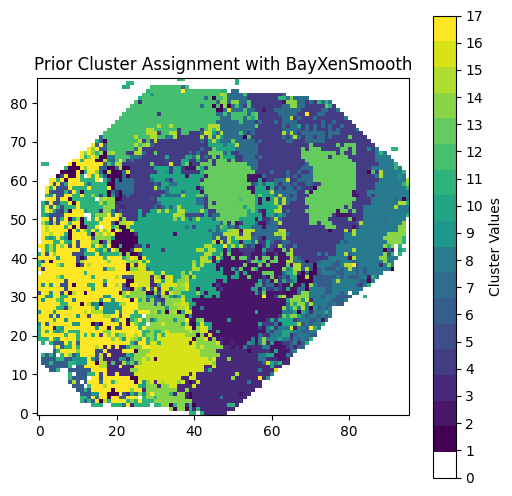

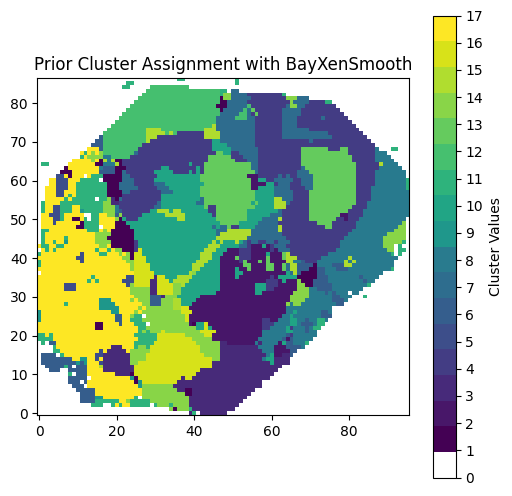

In [6]:
print(f"Batch Size is {batch_size}.")
# Clear the param store in case we're in a REPL
pyro.clear_param_store()

# Clamping
MIN_CONCENTRATION = 0.1

spatial_init_data = gene_data
empirical_prior_means = torch.ones(num_clusters, spatial_init_data.shape[1])
empirical_prior_scales = torch.ones(num_clusters, spatial_init_data.shape[1])

if spatial_init:

    spatial_init_data = np.concatenate((spatial_locations, gene_data), axis=1)

    if spatial_normalize:

        spatial_init_data = StandardScaler().fit_transform(spatial_init_data)
        spatial_init_data[:, :spatial_locations.shape[1]] *= spatial_normalize

if kmeans_init:

    kmeans = KMeans(n_clusters=num_clusters).fit(spatial_init_data)

    initial_clusters = kmeans.predict(spatial_init_data)
    for i in range(num_clusters):
        empirical_prior_means[i] = torch.tensor(spatial_init_data[initial_clusters == i, spatial_locations.shape[1]:].mean(axis=0))
        empirical_prior_scales[i] = torch.tensor(spatial_init_data[initial_clusters == i, spatial_locations.shape[1]:].std(axis=0))
    
    rows = spatial_locations["row"].astype(int)
    columns = spatial_locations["col"].astype(int)

    num_rows = max(rows) + 1
    num_cols = max(columns) + 1

    cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.int)
    
    cluster_grid[rows, columns] = torch.tensor(initial_clusters) + 1

    colors = plt.cm.get_cmap('viridis', num_clusters + 1)
    colormap = ListedColormap(colors(np.linspace(0, 1, num_clusters + 1)))

    plt.figure(figsize=(6, 6))
    plt.imshow(cluster_grid, cmap=colormap, interpolation='nearest', origin='lower')
    plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
    plt.title('Cluster Assignment with KMeans')

    match data_mode:
        case "PCA":
            data_file_path = f"{data_mode}/{num_pcs}"
        case "HVG": 
            data_file_path = f"{data_mode}/{hvg_var_prop}"
        case "ALL":
            data_file_path = f"{data_mode}"
        case _:
            raise ValueError("The data mode specified is not supported.")

    if not os.path.exists(bayxensmooth_clusters_filepath := save_filepath("KMeans", "clusters")):
        os.makedirs(bayxensmooth_clusters_filepath)
    _ = plt.savefig(
        f"{bayxensmooth_clusters_filepath}/result.png"
    )

    if dataset_name == "DLPFC":
        # Create a DataFrame for easier handling
        data = pd.DataFrame({
            'ClusterAssignments': initial_clusters,
            'Region': original_adata.xenium_spot_data.obs["Region"]
        })

        # Drop rows where 'Region' is NaN
        filtered_data = data.dropna(subset=['Region'])

        # Calculate ARI and NMI only for the non-NaN entries
        ari = ARI(filtered_data['ClusterAssignments'], filtered_data['Region'])
        nmi = NMI(filtered_data['ClusterAssignments'], filtered_data['Region'])
        cluster_metrics = {
            "ARI": ari,
            "NMI": nmi
        }

        data_file_path = f"{data_mode}/{num_pcs}"

        if not os.path.exists(kmeans_cluster_metrics_filepath := save_filepath("KMeans", "cluster_metrics")):
            os.makedirs(kmeans_cluster_metrics_filepath)
        with open(f"{kmeans_cluster_metrics_filepath}/wss.json", 'w') as fp:
            json.dump(cluster_metrics, fp)

    concentration_priors = torch.tensor(pd.get_dummies(initial_clusters, dtype=float).to_numpy())

else:

    concentration_priors = torch.ones((len(gene_data), num_clusters), dtype=float)

concentration_w_locations = torch.cat((torch.tensor(spatial_locations.to_numpy()), concentration_priors), dim=1)

# Clone to avoid modifying the original tensor
spatial_concentration_priors = concentration_priors.clone()

# Compute the number of elements in each dimension
num_spots = concentration_priors.shape[0]

# Initialize an empty tensor for spatial concentration priors
spatial_concentration_priors = torch.zeros_like(concentration_priors)

spot_locations = KDTree(concentration_w_locations[:, :2])
neighboring_spot_indexes = spot_locations.query_ball_point(concentration_w_locations[:, :2], r=neighborhood_size, p=1, workers=8)

# Iterate over each spot
for i in tqdm(range(num_spots)):

    # Select priors in the neighborhood
    priors_in_neighborhood = concentration_priors[neighboring_spot_indexes[i]]
    # print(neighboring_spot_indexes[i])
    # print(priors_in_neighborhood)

    # Compute the sum or mean, or apply a custom weighting function
    if neighborhood_agg == "sum":
        neighborhood_expression = priors_in_neighborhood.sum(dim=0)
    elif neighborhood_agg == "mean":
        neighborhood_expression = priors_in_neighborhood.mean(dim=0)
    else:
        raise NotImplementedError("Aggregation not supported right now.")
        # distances_in_neighborhood = (dist_x[current_mask] + 1) + (dist_y[current_mask] + 1)
        # weighted_A = torch.where(distances_in_neighborhood != 0, 1 / (distances_in_neighborhood ** 1.5), torch.zeros_like(distances_in_neighborhood)).reshape(-1, 1)
        # neighborhood_expression = (weighted_A * priors_in_neighborhood).sum(dim=0)

    # Update spatial concentration priors with the computed neighborhood expression
    # print(neighborhood_expression)
    spatial_concentration_priors[i] += neighborhood_expression

# Normalize concentration priors
concentration_priors = spatial_concentration_priors
concentration_priors += torch.distributions.half_normal.HalfNormal(0.1).sample(concentration_priors.shape)
concentration_priors /= concentration_priors.sum(dim=1, keepdim=True)
concentration_priors *= concentration_amplification

sample_for_assignment_options = [False, True]

for sample_for_assignment in sample_for_assignment_options:

    if sample_for_assignment:
        cluster_probs_prior_TRUE = dist.Dirichlet(concentration_priors).sample()
        cluster_assignments_prior = cluster_probs_prior_TRUE.argmax(dim=1)  
    else:
        # the probs aren't sampled and we calculate the EV instead
        cluster_probs_prior_FALSE = concentration_priors.softmax(dim=1)
        cluster_assignments_prior = cluster_probs_prior_FALSE.argmax(dim=1)

    # Load the data
    data = torch.tensor(gene_data).float()

    cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.long)

    cluster_grid[rows, columns] = cluster_assignments_prior + 1

    colors = plt.cm.get_cmap('viridis', num_clusters + 1)
    
    colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, num_clusters))))
    colormap = ListedColormap(colormap_colors)

    plt.figure(figsize=(6, 6))
    plt.imshow(cluster_grid, cmap=colormap, interpolation='nearest', origin='lower')
    plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
    plt.title('Prior Cluster Assignment with BayXenSmooth')

    if not os.path.exists(bayxensmooth_clusters_filepath := save_filepath("BayXenSmooth", "clusters", sample_for_assignment)):
        os.makedirs(bayxensmooth_clusters_filepath)
    _ = plt.savefig(
        f"{bayxensmooth_clusters_filepath}/prior_result.png"
    )

In [7]:
def model(data):

    # Define the means and variances of the Gaussian components
    cluster_means = pyro.sample("cluster_means", dist.LogNormal(0., 1.).expand([num_clusters, data.size(1)]).to_event(2))
    cluster_scales = pyro.sample("cluster_scales", dist.LogNormal(0., 1.).expand([num_clusters, data.size(1)]).to_event(2))

    # Define priors for the cluster assignment probabilities and Gaussian parameters
    with pyro.plate("data", len(data), subsample_size=batch_size) as ind:
        batch_data = data[ind]
        batch_concentration_priors = concentration_priors[ind]
        cluster_probs = pyro.sample("cluster_probs", dist.Dirichlet(batch_concentration_priors))
        # Likelihood of data given cluster assignments
        for i in range(cluster_probs.size(0)):
            pyro.sample(f"obs_{i}", dist.MixtureOfDiagNormals(cluster_means, cluster_scales, cluster_probs[i]), obs=batch_data[i])

def guide(data):
    # Initialize cluster assignment probabilities for the entire dataset
    cluster_concentration_params_q = pyro.param("cluster_concentration_params_q", concentration_priors, constraint=dist.constraints.positive) + MIN_CONCENTRATION
    # Global variational parameters for means and scales
    cluster_means_q = pyro.param("cluster_means_q", torch.ones(num_clusters, data.size(1)), constraint=dist.constraints.positive)
    cluster_scales_q = pyro.param("cluster_scales_q", torch.ones(num_clusters, data.size(1)), constraint=dist.constraints.positive)
    cluster_means = pyro.sample("cluster_means", dist.LogNormal(cluster_means_q, 1.0).to_event(2))
    cluster_scales = pyro.sample("cluster_scales", dist.LogNormal(cluster_scales_q, 1.0).to_event(2))
    
    with pyro.plate("data", len(data), subsample_size=batch_size) as ind:

        batch_cluster_concentration_params_q = cluster_concentration_params_q[ind] + MIN_CONCENTRATION
        cluster_probs = pyro.sample("cluster_probs", dist.Dirichlet(batch_cluster_concentration_params_q))

In [8]:
NUM_EPOCHS = 1
NUM_BATCHES = int(math.ceil(data.shape[0] / batch_size))

# Setup the optimizer
adam_params = {"lr": 0.001, "betas": (0.90, 0.999)}
scheduler = PyroOptim(Adam, adam_params)

# Setup the inference algorithm
svi = SVI(model, guide, scheduler, loss=Trace_ELBO(num_particles=10))

epoch_pbar = tqdm(range(NUM_EPOCHS))
for epoch in epoch_pbar:
    epoch_pbar.set_description(f"Epoch {epoch}")
    running_loss = 0.0
    batch_pbar = tqdm(range(NUM_BATCHES))
    for step in batch_pbar:
        batch_pbar.set_description(f"Step {step}")
        loss = svi.step(data)
        running_loss += loss / batch_size
    # svi.optim.step()
    if epoch % 1 == 0:
        print(f"Epoch {epoch} : loss = {round(running_loss/1e6, 4)}")
        cluster_concentration_params_q = pyro.param("cluster_concentration_params_q", concentration_priors, constraint=dist.constraints.positive) + MIN_CONCENTRATION
        if sample_for_assignment:
            cluster_probs_q = pyro.sample("cluster_probs", dist.Dirichlet(cluster_concentration_params_q)).detach()     
        else:
            # the probs aren't sampled and we calculate the EV instead
            cluster_probs_q = cluster_concentration_params_q.softmax(dim=1)
        cluster_assignments_q = cluster_probs_q.argmax(dim=1)

        if dataset_name == "DLPFC":
            # Create a DataFrame for easier handling
            cluster_data = pd.DataFrame({
                'ClusterAssignments': cluster_assignments_q,
                'Region': original_adata.xenium_spot_data.obs["Region"]
            })

            # Drop rows where 'Region' is NaN
            filtered_data = cluster_data.dropna(subset=['Region'])

            # Calculate ARI and NMI only for the non-NaN entries
            ari = ARI(filtered_data['ClusterAssignments'], filtered_data['Region'])
            nmi = NMI(filtered_data['ClusterAssignments'], filtered_data['Region'])
            print(f"Step {step} : ARI = {ari} NMI = {nmi}")

Epoch 0: 100%|██████████| 1/1 [01:46<00:00, 106.19s/it]

Epoch 0 : loss = 268.9583


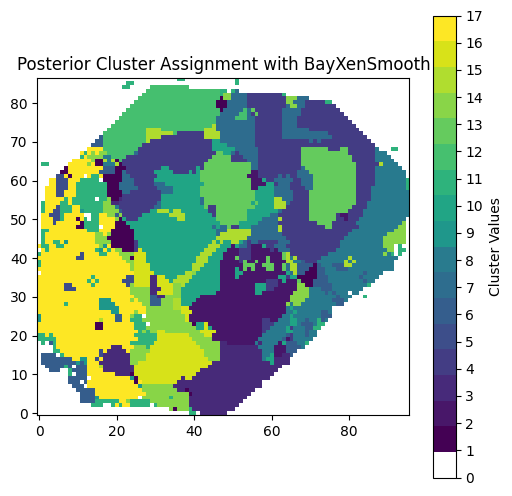

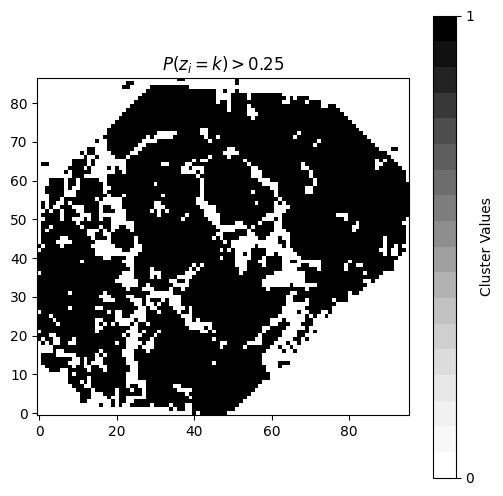

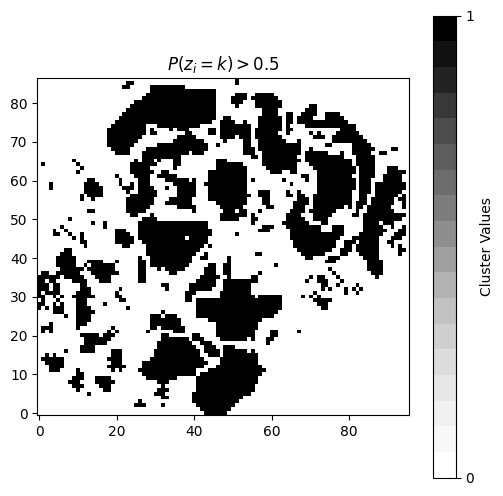

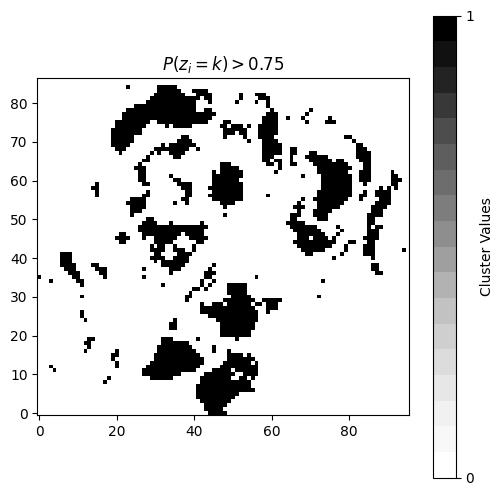

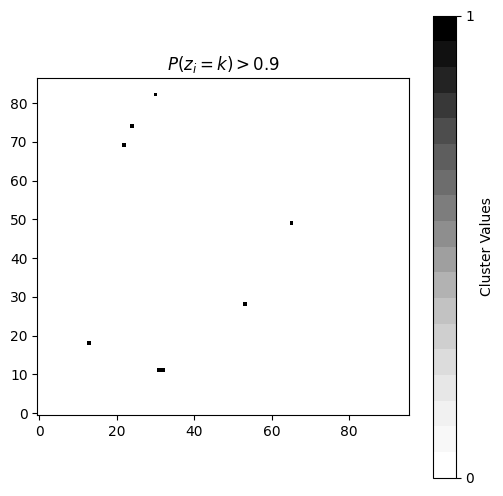

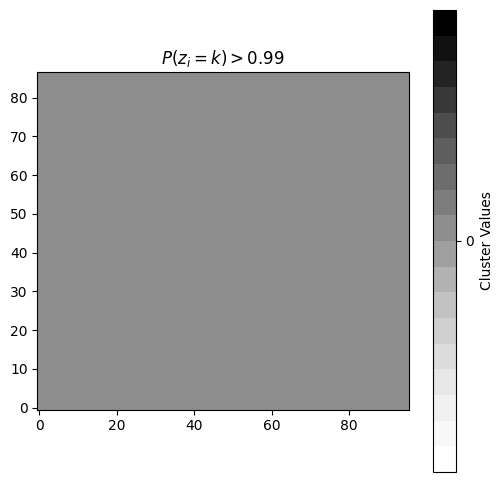

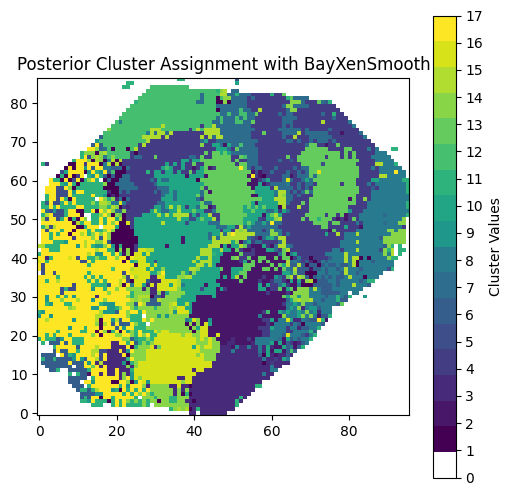

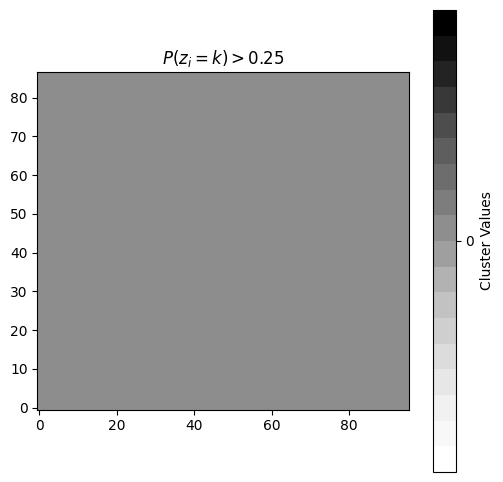

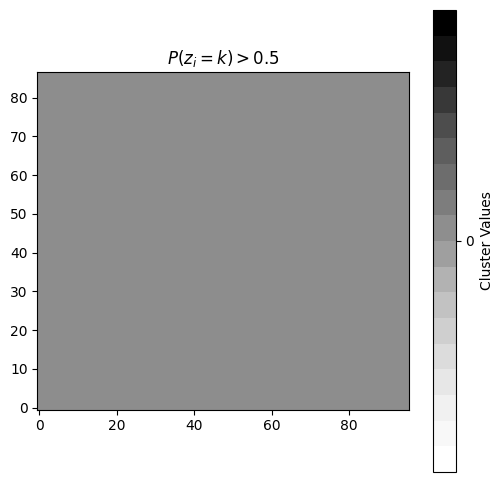

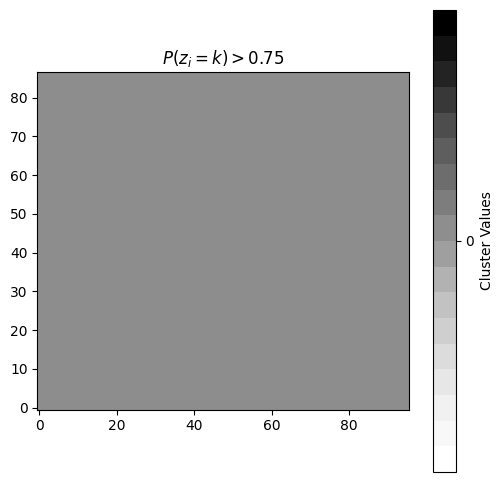

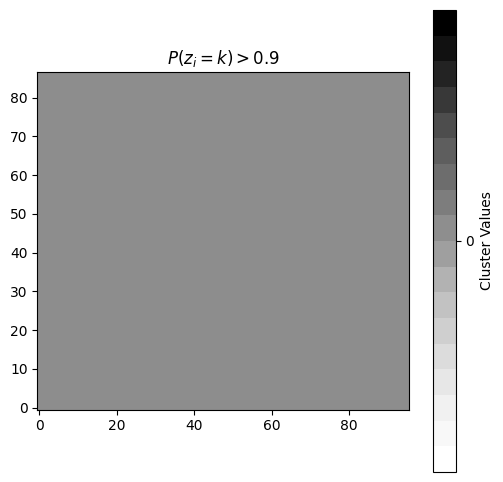

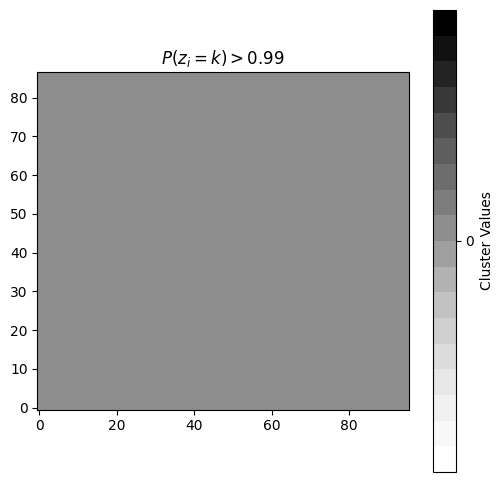

In [21]:
# Grab the learned variational parameters
num_posterior_samples = 10000
sample_for_assignment_options = [False, True]

for sample_for_assignment in sample_for_assignment_options:

    cluster_concentration_params_q = pyro.param("cluster_concentration_params_q")
    cluster_probs_q = 0
    if sample_for_assignment:
        cluster_probs_q += (1 / num_posterior_samples) * pyro.sample("cluster_probs", dist.Dirichlet(cluster_concentration_params_q)).detach()  
        # retrieve the relevant prior for comparison
        cluster_probs_prior_TRUE = dist.Dirichlet(concentration_priors).sample()
        cluster_assignments_prior = cluster_probs_prior_TRUE.argmax(dim=1)     
    else:
        # the probs aren't sampled and we calculate the EV instead
        cluster_probs_q = cluster_concentration_params_q.softmax(dim=1)
        # retrieve the relevant prior for comparison
        cluster_probs_prior_FALSE = concentration_priors.softmax(dim=1)
        cluster_assignments_prior = cluster_probs_prior_FALSE.argmax(dim=1)
    cluster_assignments_q = cluster_probs_q.argmax(dim=1)
    
    cluster_concentration_params_q = cluster_concentration_params_q.detach()
    cluster_means_q = pyro.param("cluster_means_q").detach()
    cluster_scales_q = pyro.param("cluster_scales_q").detach()
    cluster_probs_q = cluster_probs_q.detach()

    # Plotting
    if spot_size:

        rows = spatial_locations["row"].astype(int)
        columns = spatial_locations["col"].astype(int)

        num_rows = max(rows) + 1
        num_cols = max(columns) + 1

        cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.long)

        cluster_grid[rows, columns] = cluster_assignments_q + 1

        colors = plt.cm.get_cmap('viridis', num_clusters + 1)

        colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, num_clusters))))
        colormap = ListedColormap(colormap_colors)

        plt.figure(figsize=(6, 6))
        plt.imshow(cluster_grid, cmap=colormap, interpolation='nearest', origin='lower')
        plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
        plt.title('Posterior Cluster Assignment with BayXenSmooth')

        match data_mode:
            case "PCA":
                data_file_path = f"{data_mode}/{num_pcs}"
            case "HVG": 
                data_file_path = f"{data_mode}/{hvg_var_prop}"
            case "ALL":
                data_file_path = f"{data_mode}"
            case _:
                raise ValueError("The data mode specified is not supported.")

        if not os.path.exists(bayxensmooth_clusters_filepath := save_filepath("BayXenSmooth", "clusters", sample_for_assignment)):
            os.makedirs(bayxensmooth_clusters_filepath)
        _ = plt.savefig(
            f"{bayxensmooth_clusters_filepath}/result.png"
        )

        clusters = pd.DataFrame(cluster_assignments_q, columns=["BayXenSmooth cluster"]).to_csv(f"{bayxensmooth_clusters_filepath}/clusters_K={num_clusters}.csv")
        soft_clusters = pd.DataFrame(cluster_probs_q, columns=[f'P(z_i = {i})'  for i in range(1, num_clusters + 1)]).to_csv(f"{bayxensmooth_clusters_filepath}/soft_clusters_K={num_clusters}.csv")

        if not os.path.exists(bayxensmooth_similar_filepath := save_filepath("BayXenSmooth", "prior_v_posterior", sample_for_assignment)):
            os.makedirs(bayxensmooth_similar_filepath)
        with open(f"{bayxensmooth_similar_filepath}/similarity.txt", 'w') as fp:
            fp.write(str(torch.mean((cluster_assignments_prior == cluster_assignments_q).float()).item()))

        # grab the WSS distance of cluster labels
        wss = {}
        for label in range(1, num_clusters + 1):
            current_cluster_locations = torch.stack(torch.where((cluster_grid == label)), axis=1).to(float)
            wss[f"Cluster {label}"] = (spot_size ** 2) * torch.mean(torch.cdist(current_cluster_locations, current_cluster_locations, p = 2)).item()

        if not os.path.exists(bayxensmooth_wss_filepath := save_filepath("BayXenSmooth", "wss", sample_for_assignment)):
            os.makedirs(bayxensmooth_wss_filepath)
        with open(f"{bayxensmooth_wss_filepath}/wss.json", 'w') as fp:
            json.dump(wss, fp)

        cmap = get_cmap('rainbow')

        if isinstance(original_adata.xenium_spot_data.X, csr_matrix):
            labels = np.unique(cluster_assignments_q)  # Define the number of clusters
            gene_columns = original_adata.xenium_spot_data.var.index  # Column names from another source
            mean_expression_by_cluster = pd.DataFrame(columns=gene_columns)

            # Loop through each cluster label
            for label in labels:
                # Find indexes of current cluster
                current_cluster_indexes = torch.where(cluster_assignments_q == label)[0].numpy()
                
                # Efficiently extract the rows for the current cluster using fancy indexing
                expressions = original_adata.xenium_spot_data.X[current_cluster_indexes, :]
                print(label, expressions.shape)
                
                # Compute mean expressions; the result is still a csr_matrix
                mean_expressions = expressions.mean(axis=0)
                
                # Convert mean_expressions to a dense format and then to a DataFrame
                mean_expressions_df = pd.DataFrame(mean_expressions.A, columns=gene_columns)
                
                # Append the result to the mean_expression_by_cluster DataFrame
                mean_expression_by_cluster = pd.concat([mean_expression_by_cluster, mean_expressions_df], ignore_index=True)
        else:
            # identify marker genes within each cluster
            mean_expression_by_cluster = pd.DataFrame(columns=original_adata.xenium_spot_data.var.index)

            for label in range(num_clusters):
                current_cluster_indexes = list(torch.where(cluster_assignments_q == label)[0])
                expressions = pd.DataFrame(original_adata.xenium_spot_data.X, columns=original_adata.xenium_spot_data.var.index).iloc[current_cluster_indexes, :]
                mean_expressions = expressions.mean(axis=0).to_frame().T
                mean_expression_by_cluster = pd.concat([mean_expression_by_cluster, mean_expressions], ignore_index=True)

        if evaluate_markers:
            for i, gene in enumerate(mean_expression_by_cluster.columns):
                # using subplots() to draw vertical lines 
                fig, ax = plt.subplots(figsize=(6, 6)) 
                ax.vlines(mean_expression_by_cluster[gene].index, ymin=0, ymax=mean_expression_by_cluster[gene], color=cmap(i / (len(mean_expression_by_cluster.columns) - 1))) 
                
                # drawing the markers
                ax.plot(mean_expression_by_cluster[gene].index, mean_expression_by_cluster[gene], "^", c=cmap(i / (len(mean_expression_by_cluster.columns) - 1))) 
                ax.set_ylim(0) 
                
                # formatting and details 
                ax.set_xlabel('Cluster Label') 
                ax.set_ylabel('Mean Expression') 
                ax.set_title(gene) 
                ax.set_xticks(mean_expression_by_cluster[gene].index) 
                if not os.path.exists(bayxensmooth_expression_filepath := save_filepath("BayXenSmooth", "expressions", sample_for_assignment)):
                    os.makedirs(f"{bayxensmooth_expression_filepath}")
                _ = plt.savefig(
                    f"{bayxensmooth_expression_filepath}/GENE={gene}.png"
                )
        
        # confidence mapping
        cluster_confidences = torch.zeros((num_rows, num_cols), dtype=torch.double)

        cluster_confidences[rows, columns] = cluster_probs_q.max(dim=1).values

        colors = plt.cm.get_cmap('Greys', num_clusters + 1)
        colormap = ListedColormap(colors(np.linspace(0, 1, num_clusters + 1)))

        confidence_proportions = {}
        for uncertainty_value in uncertainty_values:
            confidence_matrix = (cluster_confidences > uncertainty_value).float()
            confidence_proportions[uncertainty_value] = torch.mean(confidence_matrix).item()
            plt.figure(figsize=(6, 6))
            plt.imshow(cluster_confidences > uncertainty_value, cmap=colormap, interpolation='nearest', origin='lower')
            plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
            # PLOT ALL UNCERTAINTY VALUESs
            plt.title(r'$P(z_i = k) > $' + f'{uncertainty_value}')
            if not os.path.exists(bayxensmooth_uncertainty_filepath := save_filepath("BayXenSmooth", "uncertainty", sample_for_assignment)):
                os.makedirs(bayxensmooth_uncertainty_filepath)
            _ = plt.savefig(
                f"{bayxensmooth_uncertainty_filepath}/CONFIDENCE={uncertainty_value}.png"
            )

    else:

        plt.scatter(spatial_locations["x_location"], spatial_locations["y_location"], s=1, c=cluster_assignments_q)
        if not os.path.exists(bayxensmooth_clusters_filepath := save_filepath("BayXenSmooth", "clusters", sample_for_assignment)):
            os.makedirs(bayxensmooth_clusters_filepath)
        _ = plt.savefig(
            f"{bayxensmooth_clusters_filepath}/result.png"
        )

Text(0.5, 1.0, 'Posterior Cluster Assignment with BayXenSmooth')

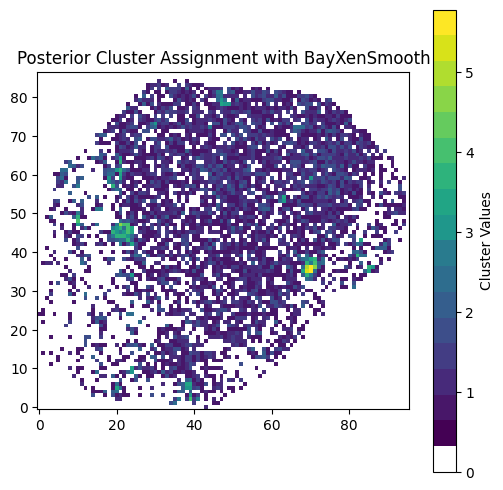

In [ ]:
colors = plt.cm.get_cmap('viridis', num_clusters + 1)

colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, num_clusters))))
colormap = ListedColormap(colormap_colors)

rows = spatial_locations["row"].astype(int)
columns = spatial_locations["col"].astype(int)

num_rows = max(rows) + 1
num_cols = max(columns) + 1

cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.double)

cluster_grid[rows, columns] = torch.tensor(original_adata.xenium_spot_data[:, ["BANK1"]].X).squeeze()

plt.figure(figsize=(6, 6))
plt.imshow(cluster_grid, cmap=colormap, interpolation='nearest', origin='lower')
plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
plt.title('Posterior Cluster Assignment with BayXenSmooth')


In [ ]:
original_adata.xenium_spot_data[:, ["BANK1"]].X

ArrayView([[0.],
           [0.],
           [0.],
           ...,
           [0.],
           [0.],
           [0.]])